___Author: Mikael Koli___

In [1]:
import sys
sys.path.append("../..")

In [2]:
import jubox
jubox.__version__

'0.2.0'

# Recipe: Pipelining Jupyter
This is a short demo to demonstrate how to parametrize a notebook, 
add custom information as markdown and then run the notebook and save the results using Jubox.

## Loading the notebook

In [3]:
from jubox import JupyterNotebook, CodeCell, MarkdownCell

In [4]:
task_name = "tasks/example_etl.ipynb"
nb = JupyterNotebook(task_name)

# We also clear all outputs if there are
# any left from last run
nb.clear_outputs(inplace=True)

## Adding parameters

In [5]:
# Set parameters
import datetime
params = CodeCell.from_variable_dict(
    start_date=datetime.datetime(2020, 2, 16),
    end_date=datetime.datetime(2020, 2, 20),
    categories=["A", "B", "D"],
)
params.insert(0, "import datetime\n")

param_cell = nb.get_cells(tags=["parameters"])[0]

# We also include datetime importing as we use it in the
# parameters
param_cell.insert(0, 'import datetime\n')

param_cell.overwrite(params)

In [6]:
nb[:3]

## Adding run info

In [7]:
# Insert some relevant run info at the start

import platform
import pandas as pd

runinfo = f"""
***Run info (generated by scheduler)***
- Start date: `{datetime.date.today():%Y-%m-%d}`
- Start time: `{datetime.datetime.now():%H:%M}`
- Using Python `{platform.python_version()}`
    - Using Pandas `{pd.__version__}`
***
"""
nb.insert(0, MarkdownCell(runinfo))

In [8]:
nb[:4]

## Running the notebook

### Utils for running the notebook

In [9]:
# We make a dummy function to illustrate
# email sending.

def send_email(receiver, subject, body):
    print("Sending email")
    

### Execution

In [10]:
# Run the notebook, and handle possible error
from nbconvert.preprocessors import CellExecutionError

try:
    nb(inplace=True)
except CellExecutionError:
    # Error occured. 
    # We get the error as HTML
    html_summary = nb.error_cells[0].get_output_as_html()
    status = "failed"
    raise
else:
    # Take the summary report that is tagged
    # with tag "summary"
    summary_cell = nb.get_cells(tags=["summary"])[0]
    html_summary = summary_cell.get_output_as_html()

    status = "succeeded"
finally:
    # Saving the notebook as HTML
    nb.to_html(f"results/{datetime.datetime.now():%Y-%m-%d}_run_book.html")
    
    # Saving the notebook with the outputs to anoher notebook
    nb.to_ipynb("results/run_task.ipynb")
    
    # Pretending to send the runned notebook's summary 
    # as email
    send_email(
        receiver="maintainer@email.com", 
        subject=f"Job {task_name} {status}", 
        body=html_summary
    )

Sending email


## Display results and the ran book

In [11]:
from IPython.core.display import display, HTML
display(HTML(html_summary))


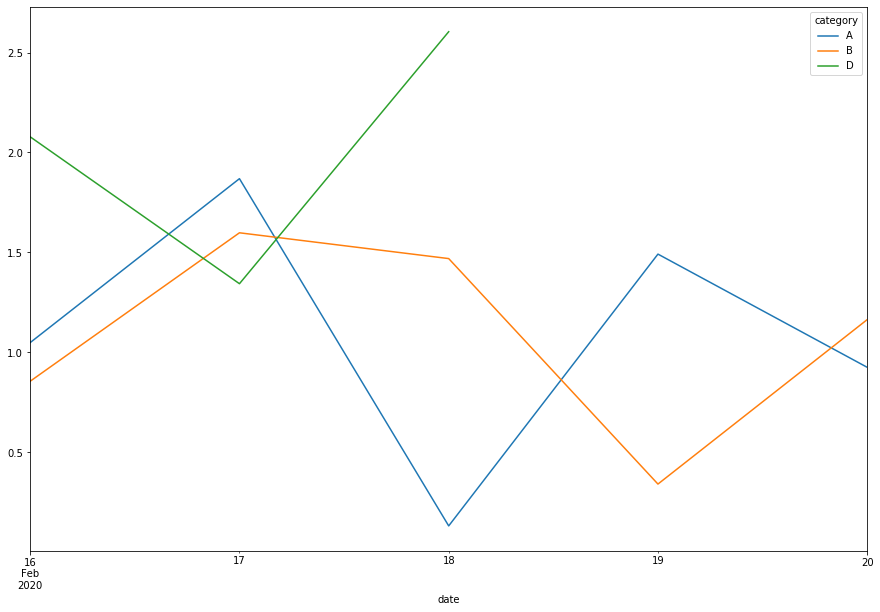
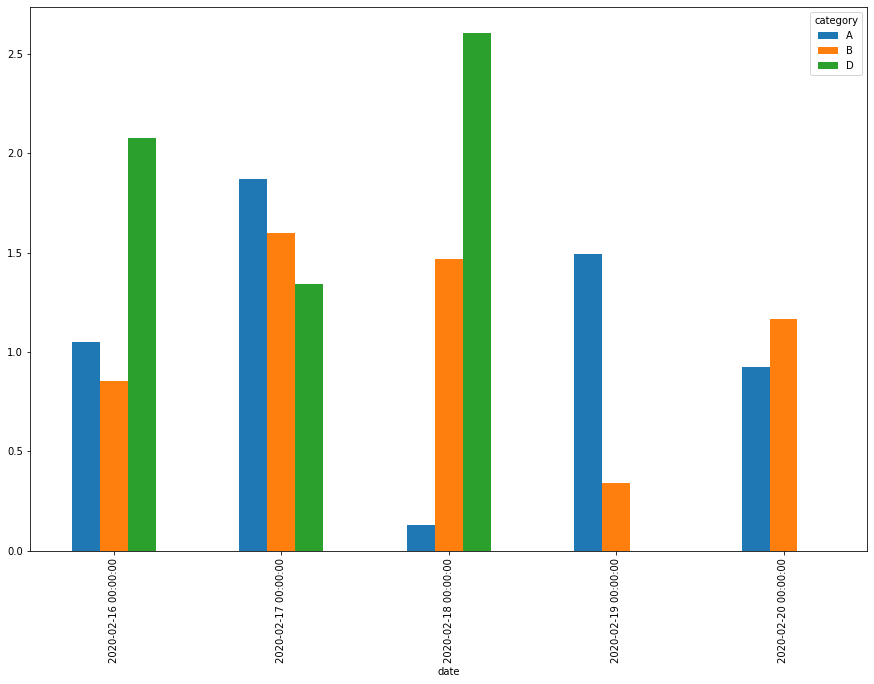

In [12]:
nb